# Proyecto 2: Ingeniería de features, Modelos avanzados e Interpretación de modelos

In [1]:
#aviso: este notebook tiene algunos warnings de los cuales no pude deshacerme aún

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
import scipy as sp
from sklearn import linear_model
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import uniform, randint
import xgboost as xgb

In [3]:
propiedades = pd.read_csv('DS_Proyecto_01_Datos_Properati.csv')

In [4]:
propiedades.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Inicialmente voy a filtrar, como en el proyecto anterior, las instancias donde surface_covered sea mayor a surface_total

In [5]:
prop = propiedades[propiedades['surface_covered'] <= propiedades['surface_total']]
prop.shape

(123099, 19)

In [6]:
prop = prop[prop.property_type.isin(['Departamento', 'Casa', 'PH'])]
prop.shape

(122306, 19)

In [7]:
prop = prop.drop_duplicates()
prop.shape

(120253, 19)

In [8]:
prop.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,112178.000000,112178.000000,120253.000000,120253.000000,118591.000000,120253.000000,120253.000000,1.202530e+05
mean,-34.598655,-58.462430,3.123664,2.063483,1.587515,184.783440,104.007850,2.430068e+05
std,0.095263,0.140084,1.376525,1.073665,0.873775,1461.359216,744.005196,2.942725e+05
min,-35.150806,-59.042416,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.620602,-58.499507,2.000000,1.000000,1.000000,52.000000,47.000000,1.150000e+05
50%,-34.598219,-58.443010,3.000000,2.000000,1.000000,78.000000,68.000000,1.699000e+05
75%,-34.571827,-58.410219,4.000000,3.000000,2.000000,138.000000,107.000000,2.683450e+05
max,-34.171414,-57.805832,35.000000,15.000000,14.000000,169000.000000,126062.000000,3.243423e+07


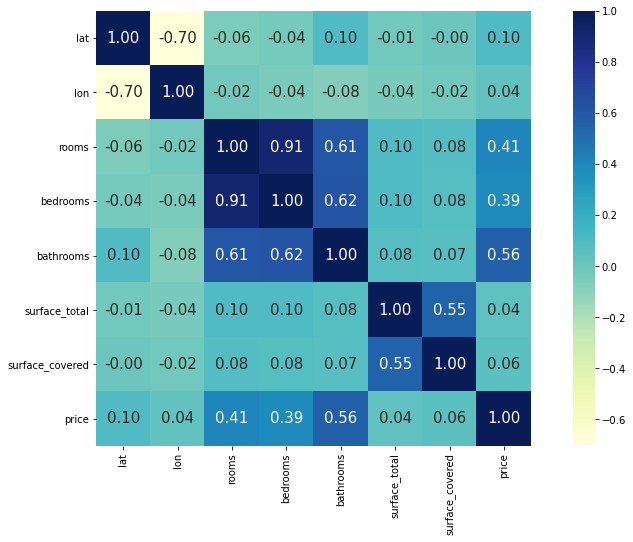

In [9]:
heatmap = prop.corr() #selecciono las columnas no categoricas
plt.figure(figsize=(15,8))
sns.heatmap(heatmap,square=True,annot=True, fmt='.2f',annot_kws={'size': 15},
            cmap='YlGnBu')

Este heatmap variará mucho con respecto al heatmap final. Durante la etapa de transformación de datos, lograremos ver qué variables se correlacionan mejor con el precio, que es lo que buscamos predecir.

# Parte A: Transformación de Datos

## Valores Faltantes

In [10]:
prop.isnull().sum(axis = 0) 

start_date            0
end_date              0
created_on            0
lat                8075
lon                8075
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms          1662
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

El porcentaje de valores faltantes en 'lat' y 'lon' es de apenas el 6,71%, y en 'bathrooms' es del 1,4%.

Dado que la cantidad de faltantes en 'lat' y 'lon' son iguales, asumimos que en las instancias en donde falta la latitud, también falta la longitud

¿Qué hacemos entonces con los 1662 ***bathrooms*** en donde hay valores faltantes?

Voy a copiar esas instancias en nuevo dataframe, ***baños_faltantes***

In [11]:
baños_faltantes = prop[prop.isnull()['bathrooms'] == True]

In [12]:
baños_faltantes.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,1537.000000,1537.000000,1662.000000,1662.000000,0.0,1662.000000,1662.000000,1.662000e+03
mean,-34.626613,-58.464519,3.094465,2.086041,NaN,235.522262,166.477136,2.001696e+05
std,0.103686,0.163208,1.391937,1.235803,NaN,1946.233128,1876.600986,1.943180e+05
min,-34.987621,-58.938387,1.000000,0.000000,NaN,12.000000,2.000000,1.300000e+04
25%,-34.647134,-58.548355,2.000000,1.000000,NaN,50.000000,44.000000,9.500000e+04
50%,-34.609423,-58.470200,3.000000,2.000000,NaN,80.000000,67.000000,1.480000e+05
75%,-34.586788,-58.409907,4.000000,3.000000,NaN,177.000000,119.750000,2.379750e+05
max,-34.301082,-57.882860,10.000000,8.000000,NaN,75792.000000,75792.000000,2.950000e+06


Del poyecto anterior, volvemos a mostrar qué distribución de tipo de propiedad hay:

[Text(0, 0, 'Departamento'), Text(0, 0, 'Casa'), Text(0, 0, 'PH')]

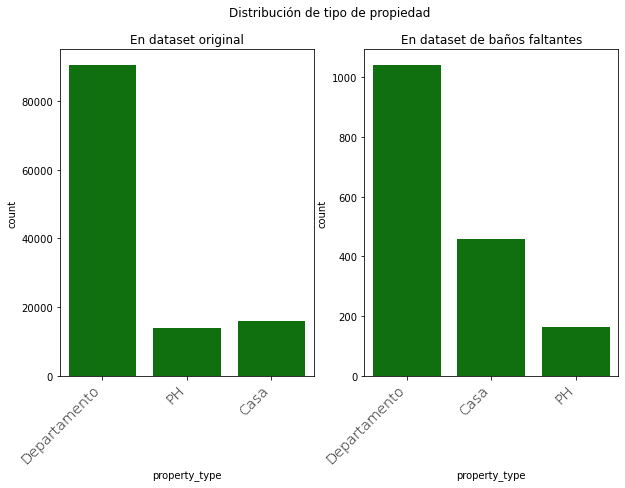

In [13]:
plt.figure(figsize=(10,6))
plt.suptitle('Distribución de tipo de propiedad')
plt.subplot(1,2,1)
plt.title('En dataset original')
grafico_propiedades = sns.countplot(data = prop, x = 'property_type', color = 'green')
grafico_propiedades.set_xticklabels(grafico_propiedades.get_xticklabels(), rotation = 45,
                                     horizontalalignment = 'right', fontweight = 'light', fontsize = 'x-large')
plt.subplot(1,2,2)
plt.title('En dataset de baños faltantes')
grafico_faltantes = sns.countplot(data = baños_faltantes, x = 'property_type', color = 'green')
grafico_faltantes.set_xticklabels(grafico_faltantes.get_xticklabels(), rotation = 45,
                                     horizontalalignment = 'right', fontweight = 'light', fontsize = 'x-large')


En lineas generales, se repite la misma tendencia con respecto al grafico del proyecto anterior: la mayor cantidad de valores (en este caso, faltantes) se da en departamentos, seguido por casas (aunque con un notorio crecimiento). El resto se mantiene similar.

A continuación vemos qué columas se correlacionan mejor con 'bathrooms', nuestros faltantes

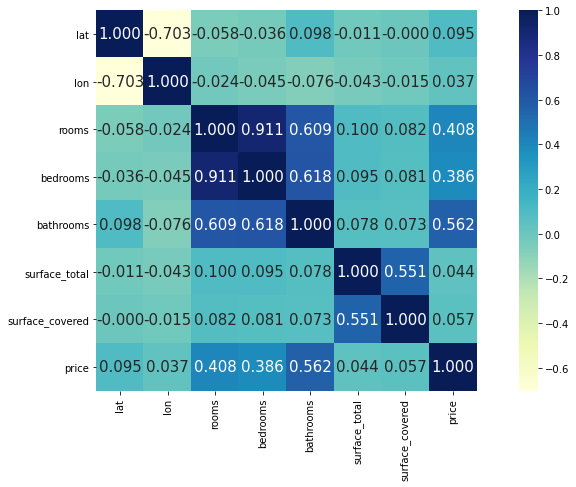

In [14]:
heatmap = prop.corr() #selecciono las columnas no categoricas
plt.figure(figsize=(15,7))
sns.heatmap(heatmap,square=True,annot=True, fmt='.3f',annot_kws={'size': 15},
            cmap='YlGnBu')

Las que más se relacionan con bathrooms son bedrooms, rooms y price, en ese orden. Sus correlaciones son similares, por eso voy a contemplarlos a los tres.

Lo que voy a hacer es imputar los valores faltantes con las instancias siguientes a ellas. Esto lo logro ordenando el dataframe según las columnas antes nombradas. De esta forma, la instancia siguiente, será una instancia aproximadamente similar a la faltante.

In [15]:
prop.sort_values(by=['bedrooms','rooms','price'], inplace=True)
prop['bathrooms'].fillna(method='ffill',inplace=True)

In [16]:
prop.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,112178.000000,112178.000000,120253.000000,120253.000000,120253.000000,120253.000000,120253.000000,1.202530e+05
mean,-34.598655,-58.462430,3.123664,2.063483,1.586663,184.783440,104.007850,2.430068e+05
std,0.095263,0.140084,1.376525,1.073665,0.873231,1461.359216,744.005196,2.942725e+05
min,-35.150806,-59.042416,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.620602,-58.499507,2.000000,1.000000,1.000000,52.000000,47.000000,1.150000e+05
50%,-34.598219,-58.443010,3.000000,2.000000,1.000000,78.000000,68.000000,1.699000e+05
75%,-34.571827,-58.410219,4.000000,3.000000,2.000000,138.000000,107.000000,2.683450e+05
max,-34.171414,-57.805832,35.000000,15.000000,14.000000,169000.000000,126062.000000,3.243423e+07


In [17]:
prop.isnull().sum(axis = 0)

start_date            0
end_date              0
created_on            0
lat                8075
lon                8075
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

In [18]:
prop.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,112178.000000,112178.000000,120253.000000,120253.000000,120253.000000,120253.000000,120253.000000,1.202530e+05
mean,-34.598655,-58.462430,3.123664,2.063483,1.586663,184.783440,104.007850,2.430068e+05
std,0.095263,0.140084,1.376525,1.073665,0.873231,1461.359216,744.005196,2.942725e+05
min,-35.150806,-59.042416,1.000000,0.000000,1.000000,10.000000,1.000000,6.000000e+03
25%,-34.620602,-58.499507,2.000000,1.000000,1.000000,52.000000,47.000000,1.150000e+05
50%,-34.598219,-58.443010,3.000000,2.000000,1.000000,78.000000,68.000000,1.699000e+05
75%,-34.571827,-58.410219,4.000000,3.000000,2.000000,138.000000,107.000000,2.683450e+05
max,-34.171414,-57.805832,35.000000,15.000000,14.000000,169000.000000,126062.000000,3.243423e+07


In [19]:
def graficar(column, n_bins=10):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(column, bins=n_bins)
    plt.subplot(1,2,2)
    sns.boxplot(data = column.values)

In [20]:
def graficar_columnas(prop):
    columns=[prop.rooms,prop.bedrooms,prop.bathrooms,prop.surface_covered,prop.surface_total,prop.price]
    for columna in columns:
        graficar(columna)

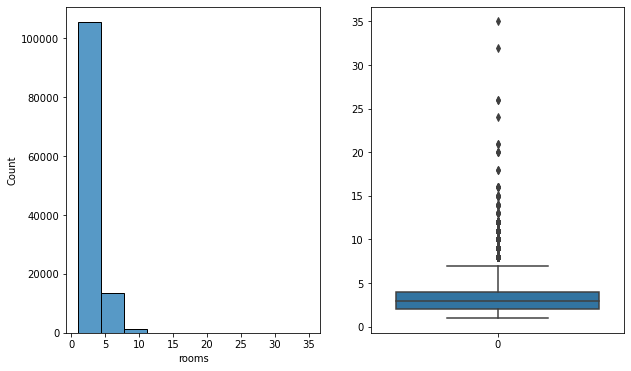

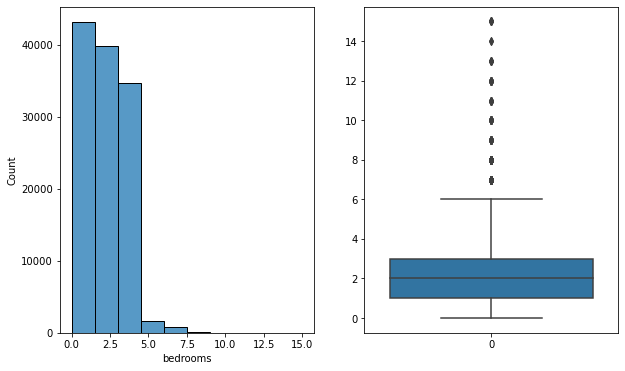

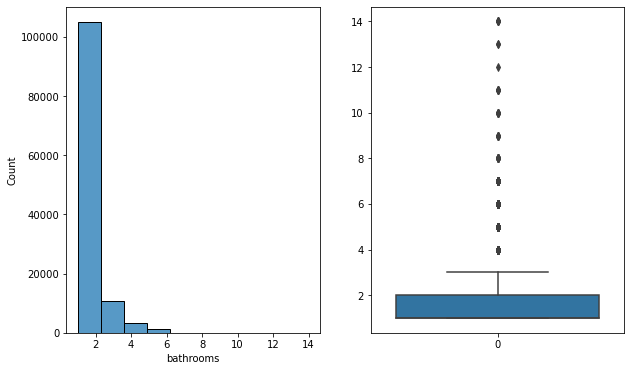

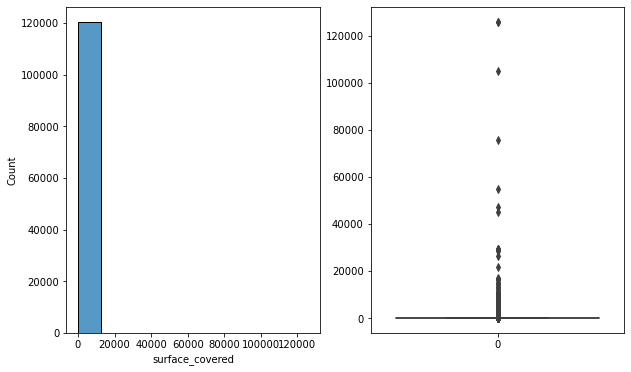

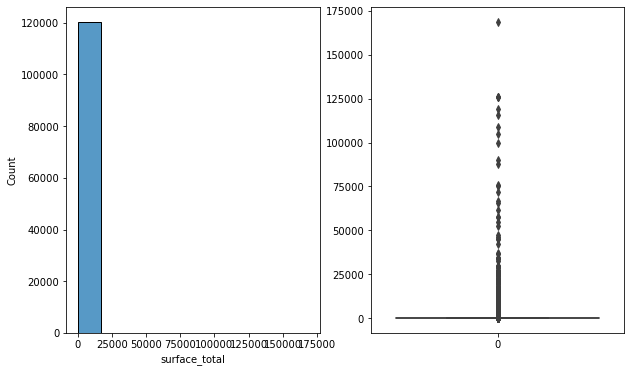

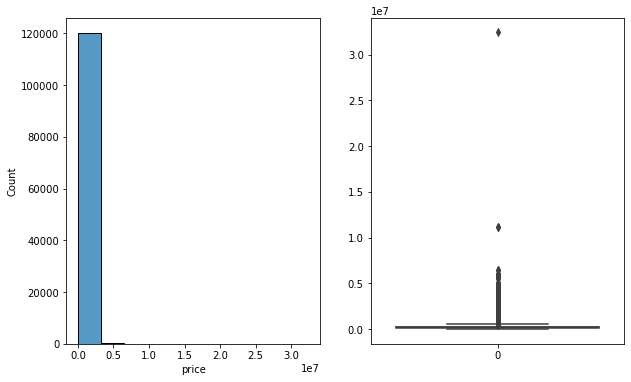

In [21]:
graficar_columnas(prop)

Ahora podríamos usar algún criterio conocido para detectar outliers. A fines de obtener un mejor rendimiento al aplicar algún modelo de machine learning, voy a probar con el de rango intercuartílico.

In [22]:
def rango_intercuartilico(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    print(IQR)
    df = df[~((df < (Q1-1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [23]:
prop.isnull().sum(axis = 0)

start_date            0
end_date              0
created_on            0
lat                8075
lon                8075
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

Aplico dos veces la técnica de rango intercuartílico, ya que elimina una mayor cantidad de outliers.

In [24]:
prop = rango_intercuartilico(prop)

lat                     0.048775
lon                     0.089288
rooms                   2.000000
bedrooms                2.000000
bathrooms               1.000000
surface_total          86.000000
surface_covered        60.000000
price              153345.000000
dtype: float64


In [25]:
prop = rango_intercuartilico(prop)

lat                     0.031095
lon                     0.058915
rooms                   1.000000
bedrooms                1.000000
bathrooms               1.000000
surface_total          48.000000
surface_covered        38.000000
price              121000.000000
dtype: float64


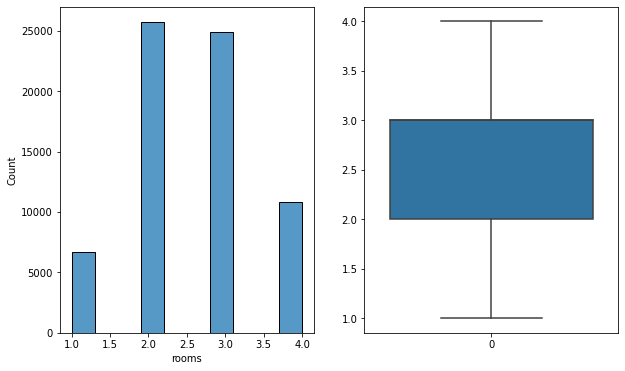

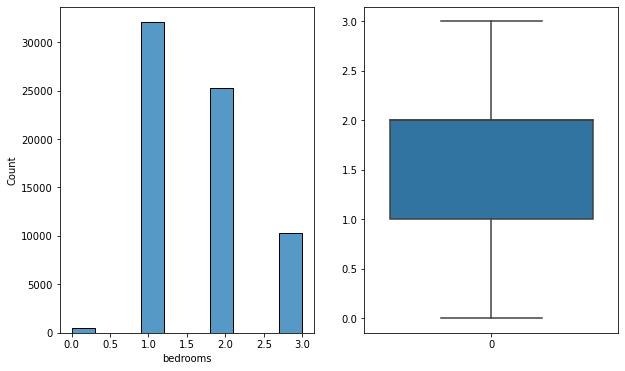

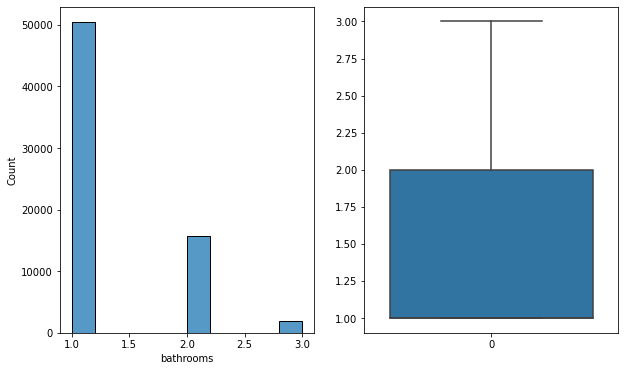

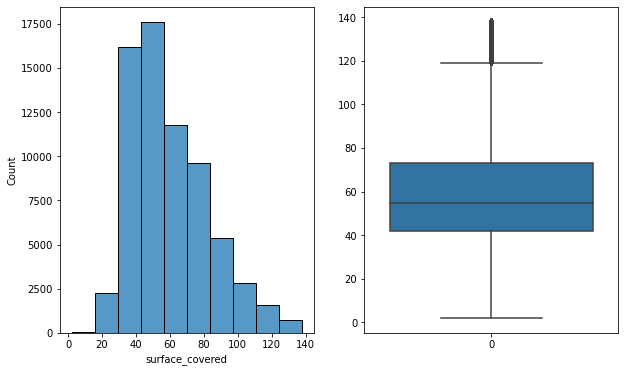

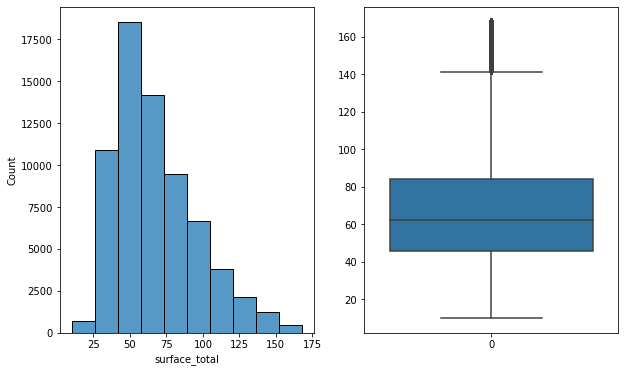

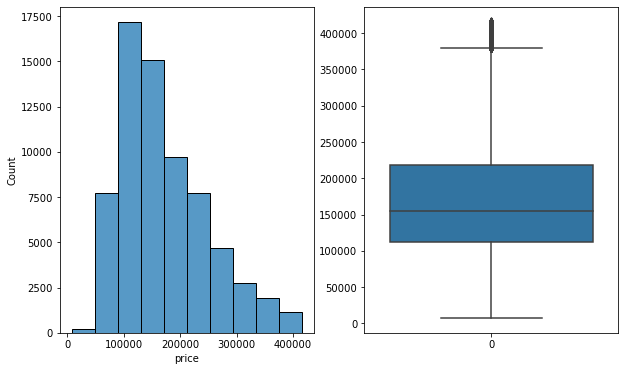

In [26]:
graficar_columnas(prop)

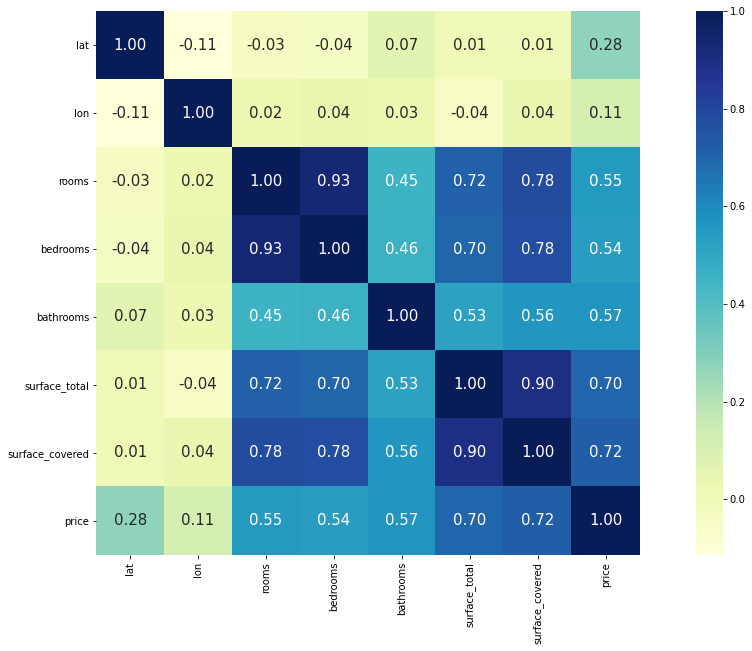

In [27]:
heatmap = prop.corr()
plt.figure(figsize=(20,10))
sns.heatmap(heatmap,square=True,annot=True, fmt='.2f',annot_kws={'size': 15},
            cmap='YlGnBu')

In [28]:
prop.describe()

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
count,62593.000000,62593.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000
mean,-34.598480,-58.440482,2.585752,1.666951,1.287905,67.599277,59.483331,171296.163147
std,0.022931,0.039508,0.870491,0.735066,0.512147,28.190472,23.037542,77223.218491
min,-34.661244,-58.561634,1.000000,0.000000,1.000000,10.000000,2.000000,7500.000000
25%,-34.612208,-58.462815,2.000000,1.000000,1.000000,46.000000,42.000000,112000.000000
50%,-34.599492,-58.435292,3.000000,2.000000,1.000000,62.000000,55.000000,155000.000000
75%,-34.584935,-58.413834,3.000000,2.000000,2.000000,84.000000,73.000000,219000.000000
max,-34.536938,-58.343911,4.000000,3.000000,3.000000,168.000000,138.000000,416172.000000


In [29]:
prop.isnull().sum(axis = 0)

start_date            0
end_date              0
created_on            0
lat                5499
lon                5499
l1                    0
l2                    0
l3                    0
rooms                 0
bedrooms              0
bathrooms             0
surface_total         0
surface_covered       0
price                 0
currency              0
title                 0
description           0
property_type         0
operation_type        0
dtype: int64

Voy a eliminar las columnas de 'lat' y 'lon' porque no tienen correlación con el precio y no aportan nada a este análisis.

In [30]:
prop.drop(columns=['lat','lon'], inplace=True)

## Escalado de datos

El objetivo es estandarizar los criterios de medida, y para eso la distribución de los datos debe tender a 0 y la desviación estandar a 1. Voy a usar el metodo z-score, y la clase StandardScaler de scikit-learn.

In [31]:
prop_norm = prop.copy()
columns = ['rooms', 'bedrooms', 'bathrooms', 'surface_covered', 'surface_total'] #no uso price por ser mi y
data = prop_norm[columns]
scaler = StandardScaler().fit(data.values)
data = scaler.transform(data.values)

Verifico que el promedio sea 0 y que la desviación estandar sea 1.

In [32]:
data.mean(axis=0)

array([-1.60282213e-16, -1.60282213e-16,  3.00529149e-16,  2.67137021e-17,
       -1.06854808e-16])

Debido a limitaciones en la representación númerica, el promedio es 'casi' cero, lo cual es lo mismo a fines prácticos.

In [33]:
data.std(axis=0)

array([1., 1., 1., 1., 1.])

In [34]:
prop_norm[columns] = data

/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


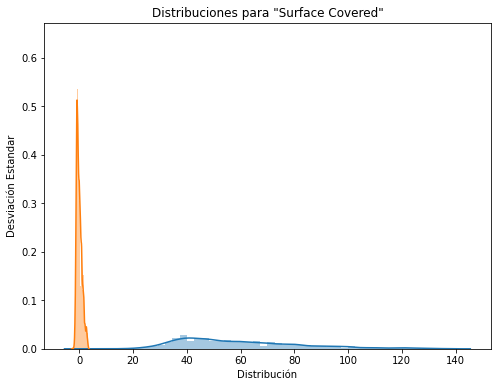

In [35]:
plt.figure(figsize=(8,6))
sns.distplot(prop.surface_covered, label = 'Datos sin Escalar')
sns.distplot(prop_norm.surface_covered, label = 'Datos Escalados')
plt.title('Distribuciones para "Surface Covered"')
plt.xlabel('Distribución')
plt.ylabel('Desviación Estandar')
plt.show()

/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


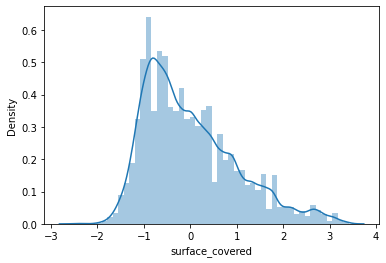

In [36]:
prop = prop_norm
sns.distplot(prop.surface_covered, label = 'Datos')

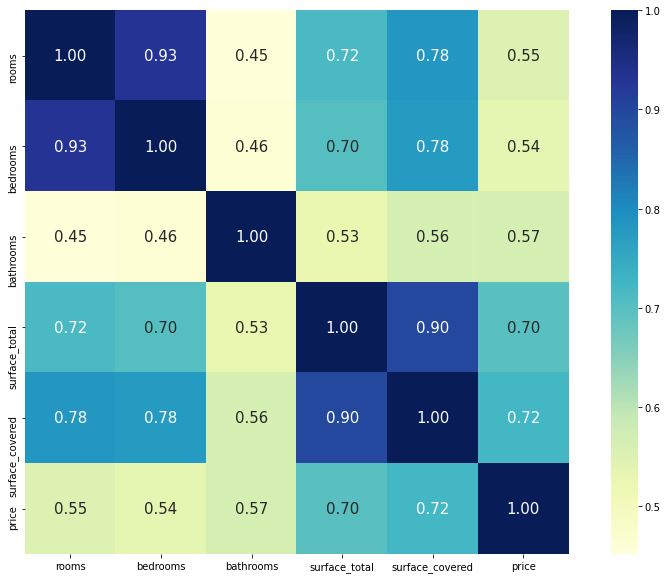

In [37]:
heatmap = prop.corr() #selecciono las columnas no categoricas
plt.figure(figsize=(15,10))
sns.heatmap(heatmap,square=True,annot=True, fmt='.2f',annot_kws={'size': 15},
            cmap='YlGnBu')

## Transformación de atributos categóricos

In [38]:
prop.dtypes

start_date          object
end_date            object
created_on          object
l1                  object
l2                  object
l3                  object
rooms              float64
bedrooms           float64
bathrooms          float64
surface_total      float64
surface_covered    float64
price              float64
currency            object
title               object
description         object
property_type       object
operation_type      object
dtype: object

Los que voy a transformar son 'property_type' y 'l3', las cuales son todas nominales (no siguen un orden). Por lo tanto, voy a usar One-Hot Encoder, a través del método `get_dummies` de pandas. Lo que hace es transformar las instancias de las variables categóricas en ceros o unos, de modo tal que se identifique a qué columna pertenece mirando dónde está el uno, ya que el resto son ceros.

Una de las nuevas columnas va a ser eliminada, dado que alcanza con representar esa información con "todos ceros"

In [39]:
prop = pd.get_dummies(prop, columns=["property_type", "l3"], prefix=['property_type','l3'])

In [40]:
prop

,start_date,end_date,created_on,l1,l2,rooms,bedrooms,bathrooms,surface_total,surface_covered,...,l3_Villa General Mitre,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
40463,2019-05-11,2019-07-10,2019-05-11,Argentina,Capital Federal,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,...,0,0,0,0,0,0,0,0,0,0
47100,2019-05-09,2019-06-27,2019-05-09,Argentina,Bs.As. G.B.A. Zona Oeste,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,...,0,0,0,0,0,0,0,0,0,0
47661,2019-05-21,2019-07-10,2019-05-21,Argentina,Capital Federal,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,...,0,0,0,0,0,0,0,0,0,0
51293,2019-03-24,2019-04-09,2019-03-24,Argentina,Bs.As. G.B.A. Zona Oeste,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,...,0,0,0,0,0,0,0,0,0,0
7389,2019-04-27,2019-07-10,2019-04-27,Argentina,Bs.As. G.B.A. Zona Oeste,-1.821688,-2.267772,-0.562156,-1.511134,-1.496843,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111962,2019-10-29,2019-12-23,2019-10-29,Argentina,Capital Federal,1.624667,1.813522,3.342999,1.965243,2.105998,...,0,0,0,0,0,0,0,0,0,0
131764,2019-10-08,9999-12-31,2019-10-08,Argentina,Capital Federal,1.624667,1.813522,1.390422,1.645984,1.628513,...,0,0,0,0,0,0,0,0,0,0
133024,2019-02-13,2019-04-16,2019-02-13,Argentina,Capital Federal,1.624667,1.813522,-0.562156,1.681457,2.279629,...,0,0,0,0,0,0,0,0,0,0
141299,2019-07-31,2019-08-14,2019-07-31,Argentina,Capital Federal,1.624667,1.813522,1.390422,2.426395,3.321415,...,0,0,0,0,0,0,0,0,0,0


In [41]:
prop.columns = prop.columns.str.replace(' ', '_')

In [42]:
prop.columns

Index(['start_date', 'end_date', 'created_on', 'l1', 'l2', 'rooms', 'bedrooms',
       'bathrooms', 'surface_total', 'surface_covered',
       ...
       'l3_Villa_General_Mitre', 'l3_Villa_Lugano', 'l3_Villa_Luro',
       'l3_Villa_Ortuzar', 'l3_Villa_Pueyrredón', 'l3_Villa_Real',
       'l3_Villa_Santa_Rita', 'l3_Villa_Soldati', 'l3_Villa_Urquiza',
       'l3_Villa_del_Parque'],
      dtype='object', length=101)

In [43]:
prop = prop.select_dtypes('number')
prop

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,l3_Abasto,...,l3_Villa_General_Mitre,l3_Villa_Lugano,l3_Villa_Luro,l3_Villa_Ortuzar,l3_Villa_Pueyrredón,l3_Villa_Real,l3_Villa_Santa_Rita,l3_Villa_Soldati,l3_Villa_Urquiza,l3_Villa_del_Parque
40463,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
47100,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
47661,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
51293,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7389,-1.821688,-2.267772,-0.562156,-1.511134,-1.496843,45000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111962,1.624667,1.813522,3.342999,1.965243,2.105998,415000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
131764,1.624667,1.813522,1.390422,1.645984,1.628513,415000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
133024,1.624667,1.813522,-0.562156,1.681457,2.279629,415000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
141299,1.624667,1.813522,1.390422,2.426395,3.321415,415000.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [44]:
prop.describe()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,l3_Abasto,...,l3_Villa_General_Mitre,l3_Villa_Lugano,l3_Villa_Luro,l3_Villa_Ortuzar,l3_Villa_Pueyrredón,l3_Villa_Real,l3_Villa_Santa_Rita,l3_Villa_Soldati,l3_Villa_Urquiza,l3_Villa_del_Parque
count,6.809200e+04,6.809200e+04,6.809200e+04,6.809200e+04,6.809200e+04,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,...,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000,68092.000000
mean,-1.602822e-16,-1.602822e-16,3.005291e-16,-1.068548e-16,2.671370e-17,171296.163147,0.007960,0.887784,0.104256,0.005008,...,0.003862,0.000382,0.006344,0.003055,0.008283,0.001571,0.003877,0.000117,0.038551,0.015479
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,77223.218491,0.088863,0.315634,0.305595,0.070590,...,0.062029,0.019537,0.079399,0.055185,0.090633,0.039610,0.062146,0.010839,0.192523,0.123449
min,-1.821688e+00,-2.267772e+00,-5.621561e-01,-2.043233e+00,-2.495221e+00,7500.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.729027e-01,-9.073405e-01,-5.621561e-01,-7.661963e-01,-7.589117e-01,112000.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.758823e-01,4.530908e-01,-5.621561e-01,-1.986245e-01,-1.946112e-01,155000.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.758823e-01,4.530908e-01,1.390422e+00,5.817867e-01,5.867279e-01,219000.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.624667e+00,1.813522e+00,3.342999e+00,3.561539e+00,3.408230e+00,416172.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Borro dos columnas, ya que ambas pueden generarse colocando 'ceros' en el resto de las columnas. Elijo las siguientes porque tienen pocas instancias:

In [45]:
prop.drop(columns=['property_type_Casa','l3_Villa_Soldati'], inplace=True)

/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [46]:
prop.shape

(68092, 90)

In [47]:
prop

,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Departamento,property_type_PH,l3_Abasto,l3_Agronomía,...,l3_Villa_Devoto,l3_Villa_General_Mitre,l3_Villa_Lugano,l3_Villa_Luro,l3_Villa_Ortuzar,l3_Villa_Pueyrredón,l3_Villa_Real,l3_Villa_Santa_Rita,l3_Villa_Urquiza,l3_Villa_del_Parque
40463,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
47100,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47661,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51293,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,40000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7389,-1.821688,-2.267772,-0.562156,-1.511134,-1.496843,45000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111962,1.624667,1.813522,3.342999,1.965243,2.105998,415000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131764,1.624667,1.813522,1.390422,1.645984,1.628513,415000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133024,1.624667,1.813522,-0.562156,1.681457,2.279629,415000.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141299,1.624667,1.813522,1.390422,2.426395,3.321415,415000.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
X = prop.drop(columns=['price'])
y = prop.price

In [49]:
columnas = list(X.columns)

### PCA

Voy a analizar los principales componentes, y de esa manera reducir la cantidad de columnas del dataset.

Finalizada esta parte, voy a entrenar el árbol de desición realizado para el proyecto 1. Luego, veremos si mejoró o no su rendimiento.

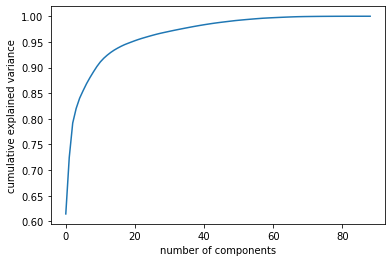

In [50]:
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [51]:
pca.explained_variance_ratio_

array([6.14562763e-01, 1.10153081e-01, 6.70263678e-02, 2.85029679e-02,
       1.99317229e-02, 1.46099909e-02, 1.37507065e-02, 1.20057976e-02,
       1.10884596e-02, 1.04395408e-02, 8.96200480e-03, 7.20249383e-03,
       5.97211451e-03, 5.25998530e-03, 4.54391341e-03, 3.89662632e-03,
       3.55011601e-03, 3.16096039e-03, 2.65434868e-03, 2.56315041e-03,
       2.51958326e-03, 2.34597008e-03, 2.15956206e-03, 1.98249843e-03,
       1.96242140e-03, 1.88534411e-03, 1.82330310e-03, 1.68513548e-03,
       1.52437843e-03, 1.45936979e-03, 1.45156365e-03, 1.44406275e-03,
       1.38108688e-03, 1.34016576e-03, 1.32744299e-03, 1.30515409e-03,
       1.27917404e-03, 1.25395821e-03, 1.21129225e-03, 1.15520556e-03,
       1.12692957e-03, 1.05905201e-03, 1.03367715e-03, 9.71673932e-04,
       9.05595544e-04, 8.58016817e-04, 8.24798459e-04, 8.09911766e-04,
       7.98030881e-04, 7.96398080e-04, 6.56676938e-04, 6.30498024e-04,
       6.15346850e-04, 5.81150709e-04, 5.67044451e-04, 5.58674527e-04,
      

Voy a usar 7 componentes, dado que mantiene un gran porcentaje (~87%) y no se agranda demasiado el dataset.

In [52]:
pca = PCA(n_components=7)
X_nuevo = pca.fit_transform(X)

Grafico la relación entre dos de los 7 componentes, por ejemplo:

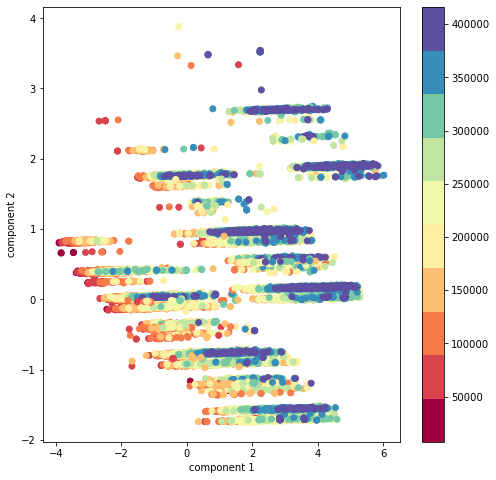

In [53]:
plt.figure(figsize=(8,8))
plt.scatter(X_nuevo[:, 0], X_nuevo[:, 1],
            c=prop.price,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

¿Cómo sabemos qué features fueron importantes?

In [54]:
n_pcs= pca.components_.shape[0]
mas_importantes = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
nombres_mas_importantes = [columnas[mas_importantes[i]] for i in range(n_pcs)]
dic = {'PC{}'.format(i): nombres_mas_importantes[i] for i in range(n_pcs)}
df = pd.DataFrame(dic.items())

In [55]:
df

,0,1
0,PC0,surface_covered
1,PC1,bathrooms
2,PC2,surface_total
3,PC3,property_type_Departamento
4,PC4,l3_Palermo
5,PC5,surface_covered
6,PC6,l3_Almagro


Ya sabemos cual es cada componente: al final del notebook veremos cuáles fueron las más importantes.

In [56]:
X_nuevo

array([[-3.90123477e+00,  8.08054371e-01, -8.27356795e-02, ...,
        -9.32936693e-02, -2.24883264e-03,  1.53085379e-02],
       [-3.84198015e+00,  6.60399435e-01,  1.73577853e-01, ...,
         1.08562106e-02, -2.86138179e-01,  7.26278508e-02],
       [-3.90223900e+00,  8.00828999e-01, -9.45853476e-02, ...,
        -1.13487149e-01, -2.64630556e-02, -4.01429528e-03],
       ...,
       [ 3.28742858e+00, -1.56702055e+00,  6.48387529e-01, ...,
        -1.09402330e-01, -3.68815457e-01, -1.04449122e-01],
       [ 4.85501994e+00,  2.69464826e-02,  1.20981707e+00, ...,
         3.00963522e-02, -9.02844358e-01,  2.10249152e-03],
       [ 4.22438107e+00,  1.88322614e+00, -8.89979986e-01, ...,
        -4.10025633e-02, -2.54513286e-01, -6.41081367e-02]])

In [57]:
X

,rooms,bedrooms,bathrooms,surface_total,surface_covered,property_type_Departamento,property_type_PH,l3_Abasto,l3_Agronomía,l3_Almagro,...,l3_Villa_Devoto,l3_Villa_General_Mitre,l3_Villa_Lugano,l3_Villa_Luro,l3_Villa_Ortuzar,l3_Villa_Pueyrredón,l3_Villa_Real,l3_Villa_Santa_Rita,l3_Villa_Urquiza,l3_Villa_del_Parque
40463,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
47100,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
47661,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
51293,-1.821688,-2.267772,-0.562156,-1.865867,-1.930920,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7389,-1.821688,-2.267772,-0.562156,-1.511134,-1.496843,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111962,1.624667,1.813522,3.342999,1.965243,2.105998,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
131764,1.624667,1.813522,1.390422,1.645984,1.628513,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
133024,1.624667,1.813522,-0.562156,1.681457,2.279629,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
141299,1.624667,1.813522,1.390422,2.426395,3.321415,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X = X_nuevo

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
tree_regressor = DecisionTreeRegressor(max_depth=5, random_state=42)

In [61]:
tree_regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 45282.08879001093
Raíz del error cuadrático medio en Test: 45913.96873521638
El puntaje r2 en Train es: 0.6567140560052704
El puntaje r2 en Test es: 0.6451371365178351


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


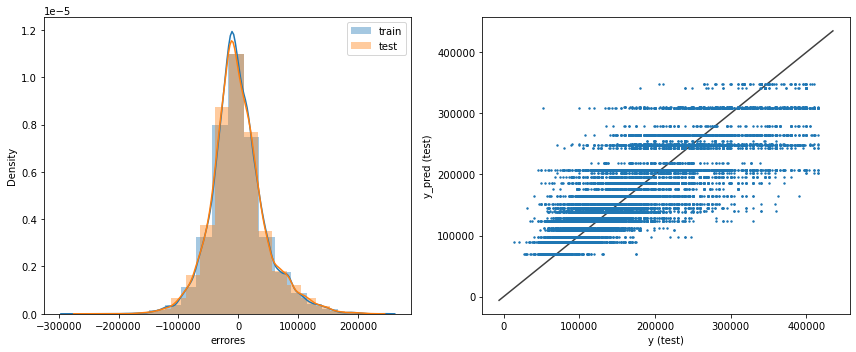

In [62]:
modelos = ['Árbol de Decisión']

for i, model in enumerate([tree_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f'Modelo: {modelos[i]}')
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"El puntaje r2 en Train es: {r2_train}")
    print(f"El puntaje r2 en Test es: {r2_test}")
    
    plt.figure(figsize = (12,5))
    
    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]), 
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

En el proyecto anterior, sin la transformación de datos, los resultados fueron:

Raíz del error cuadrático medio en Train: 216278.7175940256

Raíz del error cuadrático medio en Test: 218957.05421795268

El puntaje r2 en Train: 0.4714990135206788

El puntaje r2 en Test: 0.47536093505669097

En este proyecto, con toda la etapa de transformación de datos realizada, los resultados fueron:

Raíz del error cuadrático medio en Train: 48565.79448415504

Raíz del error cuadrático medio en Test: 49308.86373067511

El puntaje r2 en Train es: 0.6037016729042921

El puntaje r2 en Test es: 0.594620843489407

Como vemos, se redujo muchísimo la RMSE, y el r^2 score aumentó. Esto se explica por la transformación de datos, en donde por ejemplo, toma relevancia el tipo de propiedad 'Departamento', los tipos de superficies y los baños. La diferencia con el proyecto anterior es que los datos están transformados, tanto con One-Hot Encoder como con Standard Scaler, los outliers están debidamente eliminados, y reducidas las columnas a contener más de un 85% de la información.

## **Parte B: Modelos Avanzados**

### Regresión lineal (Benchmark)

In [63]:
def evaluar_regresion(model,x,y, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"El puntaje r2 en Train es: {r2_train}")
    print(f"El puntaje r2 en Test es: {r2_test}")
    
    ### GRAFICAMOS LOS RESULTADOS
    plt.figure(figsize = (12,6))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]),  
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

#### Atributos polinómicos

Antes de hacer la regularización, voy a comprobar si las distribuciones entre test y train son similares para poder aplicar validación cruzada. La regularización vendrá de la mano de ésta.

/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


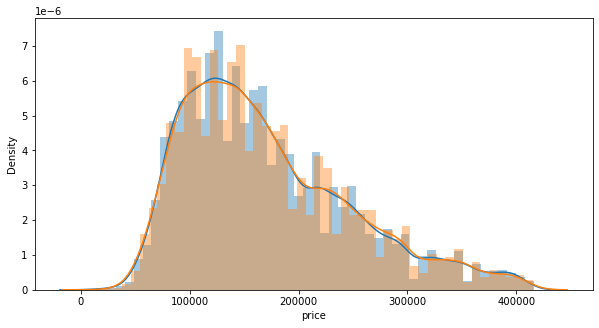

In [64]:
plt.figure(figsize=(10,5))
sns.distplot(y_train)
sns.distplot(y_test)
plt.show()

In [65]:
poly = PolynomialFeatures(degree = 3, include_bias=False)
X_train_new = poly.fit_transform(X_train)
X_test_new = poly.fit_transform(X_test)
print(X_train.shape, X_train_new.shape)

(47664, 7) (47664, 119)


#### Regularización

In [66]:
alphas_list = [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]

ridge = linear_model.Ridge(normalize=True)
hyperparams_ridge = {'alpha':[10, 5, 1, 0.5, 0.1 ,0.01, 0.005, 0.001],
                    'solver': ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg','sag','saga']
                    }

In [67]:
ridge_reg = RandomizedSearchCV(ridge, hyperparams_ridge,n_iter=25, random_state=0, cv=5)

In [68]:
X_train_new.shape, y_train.shape

((47664, 119), (47664,))

In [69]:
%%time
ridge_reg.fit(X_train_new, y_train)

CPU times: user 5min 15s, sys: 12.6 s, total: 5min 27s
Wall time: 4min 48s


RandomizedSearchCV(cv=5, estimator=Ridge(normalize=True), n_iter=25,
                   param_distributions={'alpha': [10, 5, 1, 0.5, 0.1, 0.01,
                                                  0.005, 0.001],
                                        'solver': ['auto', 'svd', 'cholesky',
                                                   'lsqr', 'sparse_cg', 'sag',
                                                   'saga']},
                   random_state=0)

In [70]:
ridge_reg.best_params_

{'solver': 'auto', 'alpha': 0.001}

In [71]:
ridge_reg.best_score_

0.7001612687234248

Raíz del error cuadrático medio en Train: 42173.67436148187
Raíz del error cuadrático medio en Test: 42787.27237631313
El puntaje r2 en Train es: 0.7022265324885812
El puntaje r2 en Test es: 0.6918230959999707


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


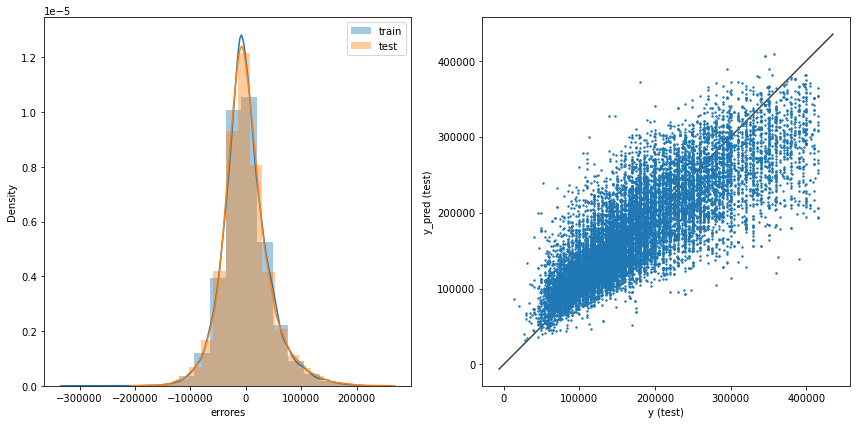

In [72]:
evaluar_regresion(ridge_reg, X, y, X_train_new, X_test_new, y_train, y_test)

In [73]:
print(X_train_new.shape,y_train.shape)

(47664, 119) (47664,)


In [74]:
%%time
lasso = linear_model.Lasso()

hyperparams_lasso = {'alpha': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10],
                      'warm_start': ['True','False'],
                      'selection': ['cyclic','random']}

lasso_reg = RandomizedSearchCV(lasso, hyperparams_lasso,n_iter=15, random_state=0, cv=5)

lasso_reg.fit(X_train_new,y_train)

/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32499931038301.527, tolerance: 22786796357.648132
  model = cd_fast.enet_coordinate_descent(
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 27183922804975.438, tolerance: 22766125047.365715
  model = cd_fast.enet_coordinate_descent(
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 25238039364323.15, tolerance: 22794421887.83722
  model = cd_fast.enet_coordinate_descen

CPU times: user 47min 51s, sys: 14.8 s, total: 48min 5s
Wall time: 24min 22s


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41863848284172.12, tolerance: 28469993524.857716
  model = cd_fast.enet_coordinate_descent(


RandomizedSearchCV(cv=5, estimator=Lasso(), n_iter=15,
                   param_distributions={'alpha': [0.001, 0.005, 0.01, 0.05, 0.1,
                                                  0.5, 1, 5, 10],
                                        'selection': ['cyclic', 'random'],
                                        'warm_start': ['True', 'False']},
                   random_state=0)

In [75]:
lasso_reg.best_params_

{'warm_start': 'True', 'selection': 'cyclic', 'alpha': 0.5}

In [76]:
lasso_reg.best_score_

0.7034878243356848

Raíz del error cuadrático medio en Train: 41922.475501122346
Raíz del error cuadrático medio en Test: 42558.45176947663
El puntaje r2 en Train es: 0.7057632216819247
El puntaje r2 en Test es: 0.6951104599255445


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


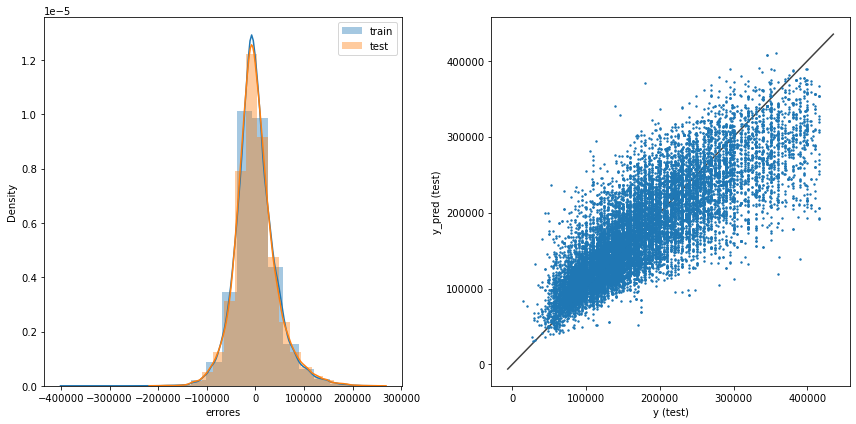

In [77]:
evaluar_regresion(lasso_reg, X, y, X_train_new, X_test_new, y_train, y_test)

## Random Forest

Voy a entrenar un Random Forest para obtener un mejor resultado, particularmente un Random Forest Regressor, ya que nuestro problema es de regresión.

In [78]:
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Raíz del error cuadrático medio en Train: 16480.1479289656
Raíz del error cuadrático medio en Test: 30603.807253199528
El puntaje r2 en Train es: 0.9545299607723834
El puntaje r2 en Test es: 0.8423398989943648


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


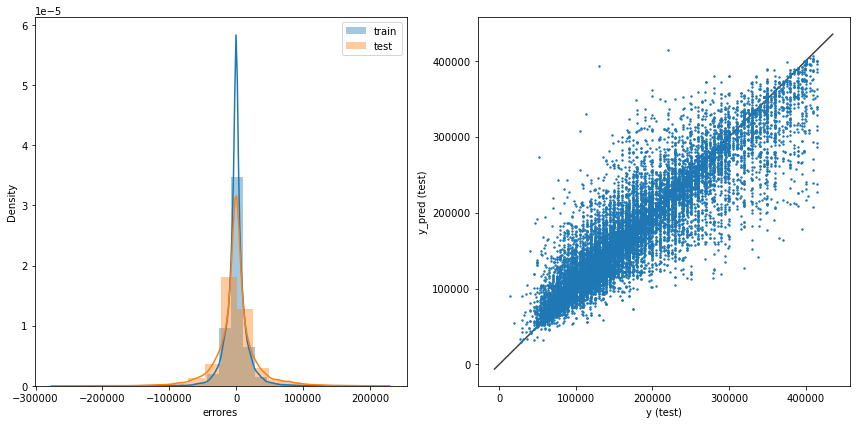

In [79]:
evaluar_regresion(rfr, X, y, X_train, X_test, y_train, y_test)

In [80]:
rfr.feature_importances_

array([0.53081626, 0.18155197, 0.03289797, 0.10321626, 0.06008599,
       0.04810878, 0.04332277])

In [81]:
random_forest = RandomForestRegressor(random_state=0)

param_dist = {
            'n_estimators': np.arange(1,30),
            'max_features': [1,2],
            'warm_start':['True','False'],
            'max_depth': [1,2,3,4,None],
            "min_samples_split": sp.stats.randint(2, 20)}
                          
rfr = RandomizedSearchCV(random_forest, param_dist,n_iter=15, random_state=0, cv=5)
rfr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_iter=15,
                   param_distributions={'max_depth': [1, 2, 3, 4, None],
                                        'max_features': [1, 2],
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3b15f013a0>,
                                        'n_estimators': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                                        'warm_start': ['True', 'False']},
                   random_state=0)

In [82]:
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)

print('Accuracy sobre conjunto de Train:', r2_score(y_train,y_train_pred))
print('Accuracy sobre conjunto de Test:', r2_score(y_test,y_test_pred))#
print("Mejores parametros: "+str(rfr.best_params_))
print("Mejor Score: "+str(rfr.best_score_)+'\n')

Accuracy sobre conjunto de Train: 0.9393525773461928
Accuracy sobre conjunto de Test: 0.821384709316508
Mejores parametros: {'max_depth': None, 'max_features': 1, 'min_samples_split': 3, 'n_estimators': 7, 'warm_start': 'False'}
Mejor Score: 0.8151103097155143



In [83]:
rfr = RandomForestRegressor(random_state=0,max_features=1,min_samples_split=3,n_estimators=7)
rfr.fit(X_train, y_train)
y_train_pred = rfr.predict(X_train)
y_test_pred = rfr.predict(X_test)
print('Accuracy sobre conjunto de Train:', r2_score(y_train,y_train_pred))
print('Accuracy sobre conjunto de Test:', r2_score(y_test,y_test_pred))

Accuracy sobre conjunto de Train: 0.9393525773461928
Accuracy sobre conjunto de Test: 0.821384709316508


## XGBoost

In [84]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

xgb_reg.fit(X_train, y_train)

y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

Raíz del error cuadrático medio en Train: 30400.61607940694
Raíz del error cuadrático medio en Test: 35122.305646481545
El puntaje r2 en Train es: 0.8452723650955258
El puntaje r2 en Test es: 0.7923476165858322


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


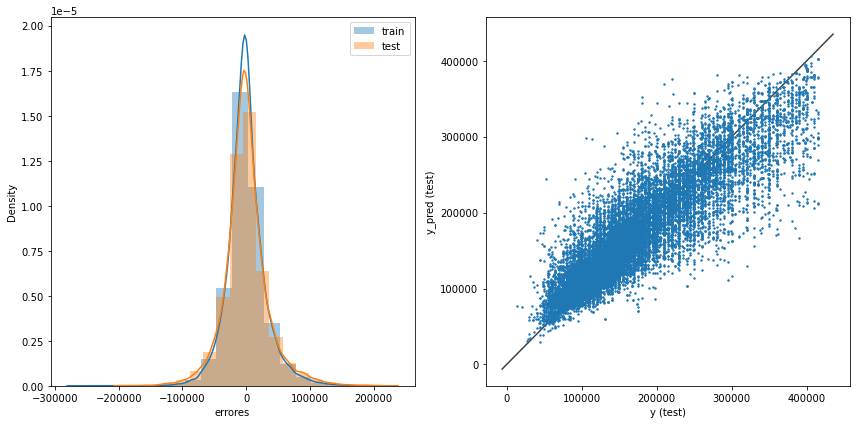

In [85]:
evaluar_regresion(xgb_reg, X, y, X_train, X_test, y_train, y_test)

#### Validación Cruzada

In [86]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

scores = cross_val_score(xgb_reg, X, y, scoring="r2", cv=5)
print(scores)

[-0.87333192 -3.22697077 -0.45763453 -2.12318561 -0.17152254]


#### Optimización de Hiperparámetros

In [87]:
xgb_model = xgb.XGBRegressor()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),
    "max_depth": randint(2, 6),
    "n_estimators": randint(100, 150),
    "subsample": uniform(0.6, 0.4)
}

xgb_reg = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=15, cv=5,return_train_score=True)

In [88]:
xgb_reg.fit(X_train, y_train)
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

print('Accuracy sobre conjunto de Train:', r2_score(y_train,y_train_pred))
print('Accuracy sobre conjunto de Test:', r2_score(y_test,y_test_pred))

Accuracy sobre conjunto de Train: 0.8334691836857562
Accuracy sobre conjunto de Test: 0.7855148164284291


In [89]:
print("Mejores parametros: "+str(xgb_reg.best_params_))
print("Mejor Score: "+str(xgb_reg.best_score_)+'\n')

Mejores parametros: {'colsample_bytree': 0.7467983561008608, 'gamma': 0.02904180608409973, 'learning_rate': 0.28985284373248055, 'max_depth': 5, 'n_estimators': 139, 'subsample': 0.8832290311184181}
Mejor Score: 0.7844535139492281



In [90]:
xgb_reg = xgb.XGBRegressor(colsample_bytree=0.7468, gamma=0.02904, learning_rate=0.28985, 
                           max_depth=5, n_estimators=139, subsample=0.88323)
xgb_reg.fit(X_train, y_train)
y_train_pred = xgb_reg.predict(X_train)
y_test_pred = xgb_reg.predict(X_test)

print('Accuracy sobre conjunto de Train:', r2_score(y_train,y_train_pred))
print('Accuracy sobre conjunto de Test:', r2_score(y_test,y_test_pred))#

Accuracy sobre conjunto de Train: 0.8313987934254053
Accuracy sobre conjunto de Test: 0.7836222171457339


El modelo que eligiría es Random Forest, dado que fue el que mejor rendimiento tuvo en base a las métricas utilizadas.

## **Parte C - Interpretación de modelos**

¿Qué variables fueron relevantes para el modelo para hacer una predicción? ¿Cuáles no? Si usaste una regresión lineal con regularización, presta atención a los parámetros (pendientes) obtenidas. Si usaste un modelo de ensamble en árboles, además de ver la importancia de cada atributo, también elige algunos árboles al azar y observa qué atributos considera importantes. ¿En qué se diferencian esos árboles? ¿Por qué? Finalmente, responde, ¿coincide con lo que esperabas a partir de tu experiencia con este dataset?
¿Cómo es la distribución de errores (regresión) o qué clases se confunden entre sí (clasificación)? ¿Dónde falla? ¿A qué se debe?

In [91]:
rfr.feature_importances_

array([0.2045172 , 0.24686789, 0.10246721, 0.16399368, 0.09455994,
       0.07438484, 0.11320925])

Feature: 0, Score: 0.20452
Feature: 1, Score: 0.24687
Feature: 2, Score: 0.10247
Feature: 3, Score: 0.16399
Feature: 4, Score: 0.09456
Feature: 5, Score: 0.07438
Feature: 6, Score: 0.11321


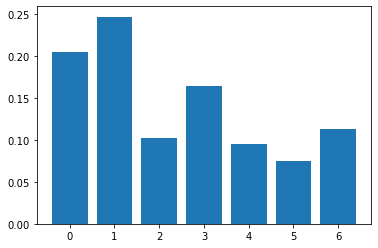

In [92]:
importances = rfr.feature_importances_
for i,j in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,j))
pyplot.bar([x for x in range(len(importances))], importances)
pyplot.show()

In [93]:
df

,0,1
0,PC0,surface_covered
1,PC1,bathrooms
2,PC2,surface_total
3,PC3,property_type_Departamento
4,PC4,l3_Palermo
5,PC5,surface_covered
6,PC6,l3_Almagro


Como vemos en el gráfico y en el dataframe, el componente más importante corresponde a 'bathrooms' con 25,5%, y lo separa de 'surface_total' apenas un 3%. Completa nuestro "podio" la columna de Departamentos. Luego, las restantes son bastante parejas, con porcentajes en promedio del 10%.

Como elegí el random forest, voy a ver cómo se comportan algunos árboles.

In [94]:
rfr.estimators_

[DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=209652396),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=398764591),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=924231285),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=1478610112),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=441365315),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=1537364731),
 DecisionTreeRegressor(max_features=1, min_samples_split=3,
                       random_state=192771779)]

In [95]:
tree_feature_imp = [tree.feature_importances_.T for tree in rfr.estimators_]

In [96]:
tree_feature_imp[:5]

[array([0.10848453, 0.26014486, 0.08048633, 0.24409487, 0.11674241,
        0.07597053, 0.11407646]),
 array([0.22066466, 0.1974715 , 0.14213333, 0.15672061, 0.06500828,
        0.06042091, 0.15758071]),
 array([0.16646292, 0.22128166, 0.07457344, 0.24333116, 0.12004114,
        0.07889993, 0.09540975]),
 array([0.26562961, 0.25755436, 0.10390087, 0.12047561, 0.06429087,
        0.0952648 , 0.09288387]),
 array([0.15933741, 0.18483118, 0.10673466, 0.18827489, 0.11536312,
        0.08569538, 0.15976336])]

Por ejemplo, mirando los 5 primeros árboles, obtenemos que:

1) 'bathrooms' fue la más importante en 3 de los 5 árboles
2) 'surface_covered' en 1, pero en segundo lugar en 3 de 5.
3) El tipo de propiedad Departamento también fue el más importante en un árbol, y dos veces en segundo lugar.


In [97]:
def plot_tree(arbol):
    fig = plt.figure(figsize=(17,10))
    plot = tree.plot_tree(arbol, max_depth=2,
                       feature_names=['surface_covered','bathrooms','surface_total',
                                      'pt_Departamento','l3_Palermo','surface_covered','l3_Almagro'],  
                       filled=True)

[0.10848453 0.26014486 0.08048633 0.24409487 0.11674241 0.07597053
 0.11407646]
[0.22066466 0.1974715  0.14213333 0.15672061 0.06500828 0.06042091
 0.15758071]
[0.16646292 0.22128166 0.07457344 0.24333116 0.12004114 0.07889993
 0.09540975]


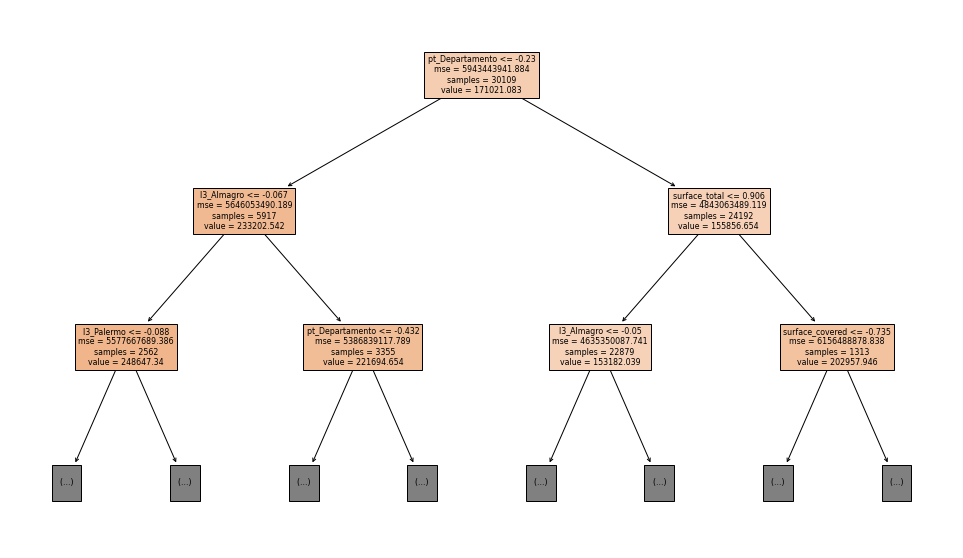

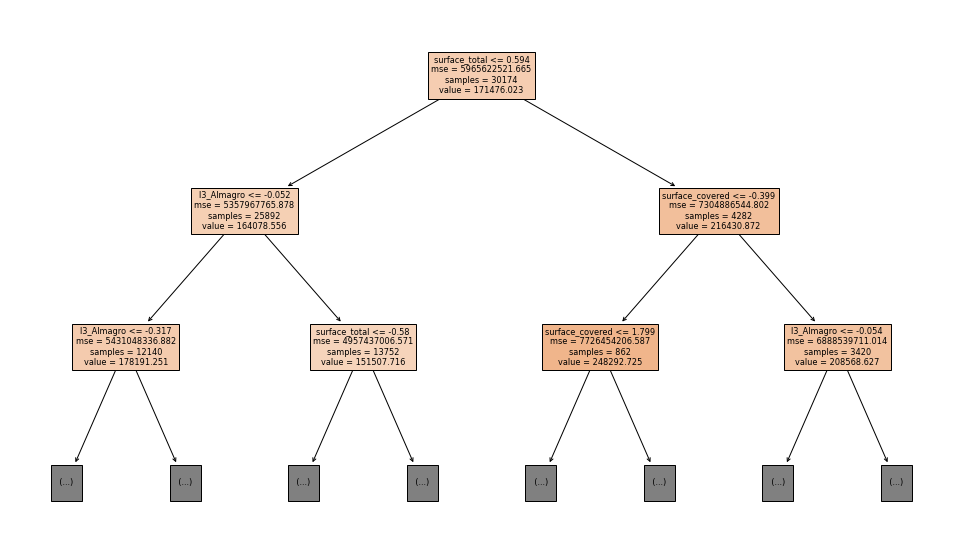

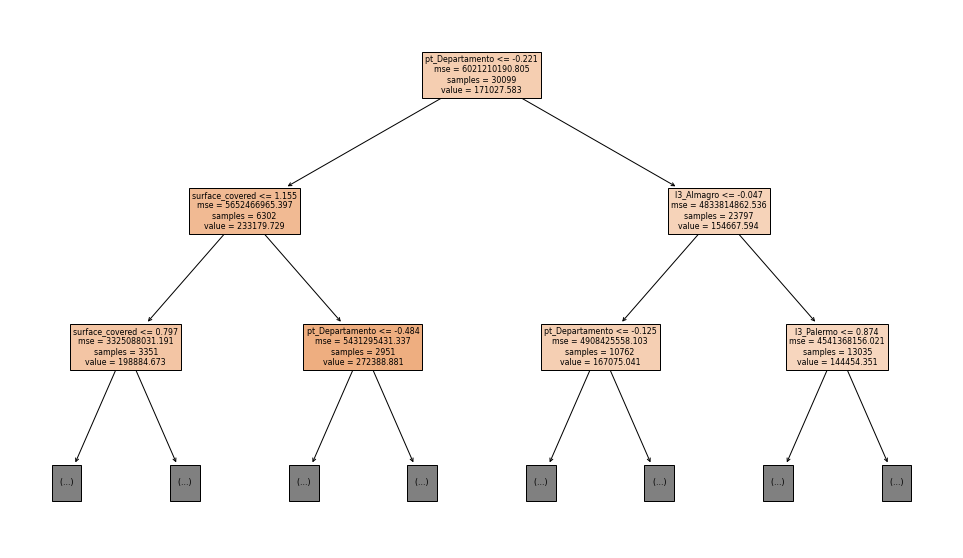

In [98]:
for arbol in rfr.estimators_[:3]:
    print(arbol.feature_importances_)
    plot_tree(arbol)

Como vemos van variando las preguntas que se hace cada árbol, y por consiguiente, su camino hacia las hojas. Esto sucede porque cada arbol se comporta de forma independiente del resto, entonces puede suceder cuaquier cosa. Con cuantos más árboles armen el bosque, menos azaroso será el resultado del random forest.

Gracias a la transformación de datos, sin dudas esperaba una mejora en el score comparado al rendimiento del Proyecto 1. También me imaginaba que los dos tipos de superficies serían determinantes. Creo que valió la pena hacer la discriminación por barrios ('l3'), ya que nos encontramos que Palermo y Almagro eran importantes.

Por último, veamos de nuevo el histograma de errores y la recta del Random Forest:

Raíz del error cuadrático medio en Train: 19032.884665588797
Raíz del error cuadrático medio en Test: 32574.208748443085
El puntaje r2 en Train es: 0.9393525773461928
El puntaje r2 en Test es: 0.821384709316508


/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mateo/Escritorio/miniconda3/envs/datascience/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


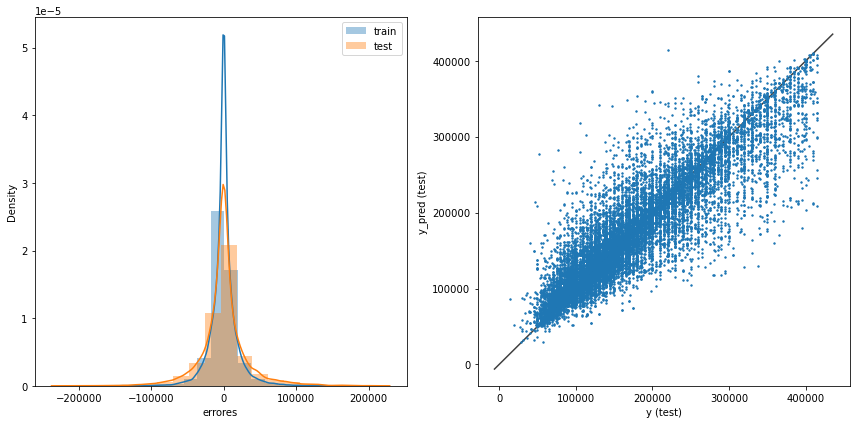

In [99]:
evaluar_regresion(rfr, X, y, X_train, X_test, y_train, y_test)

La mayoría de las propiedades parecen ubicarse en la mitad inferior de la recta. A simple vista, se nota mayor dispersión en los datos con 'y' e 'y_pred' mayor a 200000. Puede ser que la manipulación de outliers y preprocesamiento de datos en general puedad seguir mejorándose, particularmente porque hay una diferencia de casi 10 puntos entre train y test. Con la idea de no demorar mucho la ejecución del notebook, hice relativamente pocas iteraciones al optimizar hiperparámetros, y tomé menos componentes de los ideales (conservé un 85% de la información) al hacer PCA. Estas variables pueden mejorarse, conllevando un costo computacional mayor.
Sin embargo, creo que el modelo se ajustó correctamente a los datos, y gracias a la ingeniería de features previa, el modelo logró un interesante performance.